In [61]:
import pandas as pd
import numpy as np
import re
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn import model_selection

In [63]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
# lets look at the data we are looking at
train.head(3)
test.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


In [31]:

# some passengers have cabins and others don't lets give them a marker
train['Has_Cabin'] = train['Cabin'].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test['Cabin'].apply(lambda x: 0 if type(x) == float else 1)

In [32]:
full_data=[test,train]
# Create Some Additional Features

def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""


# it looks like there are some common titles like Mr., Mrs. Miss., but also some that may give more meaning like dr., captain Major
for data_set in full_data:
    data_set['Title'] = data_set['Name'].apply(get_title)
common_titles = {}
for dataset in full_data:
    for row in data_set['Title']:
        title = row
        if title in common_titles:
            common_titles[title] += 1
        else:
            common_titles[title] = 1
common_titles 

{'Mr': 1034,
 'Mrs': 250,
 'Miss': 364,
 'Master': 80,
 'Don': 2,
 'Rev': 12,
 'Dr': 14,
 'Mme': 2,
 'Ms': 2,
 'Major': 4,
 'Lady': 2,
 'Sir': 2,
 'Mlle': 4,
 'Col': 4,
 'Capt': 2,
 'Countess': 2,
 'Jonkheer': 2}

In [33]:
for key in common_titles:
    if common_titles[key] < 4:
        common_titles[key] = 1
    if key == 'Dr' or key == 'Rev':
        common_titles[key] = 2
    if key == 'Miss':
        common_titles[key] = 3
    if key == 'Mrs':
        common_titles[key] = 4
    if key == 'Mr':
        common_titles[key] = 5
    if key == 'Master':
        common_titles[key] = 6


In [34]:
common_titles
type(common_titles)

dict

In [35]:
for data_set in full_data:
    data_set['Title'] = data_set['Title'].map(common_titles)
    dataset['Title'] = dataset['Title'].fillna(0)

In [36]:
train['Title']

0      5
1      4
2      3
3      4
4      5
5      5
6      5
7      6
8      4
9      4
10     3
11     3
12     5
13     5
14     3
15     4
16     6
17     5
18     4
19     4
20     5
21     5
22     3
23     5
24     3
25     4
26     5
27     5
28     3
29     5
      ..
861    5
862    4
863    3
864    5
865    4
866    3
867    5
868    5
869    6
870    5
871    4
872    5
873    5
874    4
875    3
876    5
877    5
878    5
879    4
880    4
881    5
882    3
883    5
884    5
885    4
886    2
887    3
888    3
889    5
890    5
Name: Title, Length: 891, dtype: int64

In [37]:
train.head(4)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Has_Cabin,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,5
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,4
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,4


In [38]:
for dataset in full_data:
    dataset['Sex'] = dataset['Sex'].map({'male': 0, 'female': 1}).astype(int)
    

In [39]:
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
test = test.drop(drop_elements, axis = 1)

In [40]:
train.head(4)
test.head(4)

,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,Title
0,3,0,34.5,0,7.8292,Q,0,5.0
1,3,1,47.0,0,7.0000,S,0,4.0
2,2,0,62.0,0,9.6875,Q,0,5.0
3,3,0,27.0,0,8.6625,S,0,5.0


In [60]:
embarked_map = {'S':1,"C":2, "Q":3}
train['Embarked'] = train['Embarked'].map(embarked_map)
test['Embarked'] = test['Embarked'].map(embarked_map)

train.head(4)
test.head()

,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,Title
0,3,0,34.5,0,7.8292,NaN,0,5.0
1,3,1,47.0,0,7.0000,NaN,0,4.0
2,2,0,62.0,0,9.6875,NaN,0,5.0
3,3,0,27.0,0,8.6625,NaN,0,5.0
4,3,1,22.0,1,12.2875,NaN,0,4.0


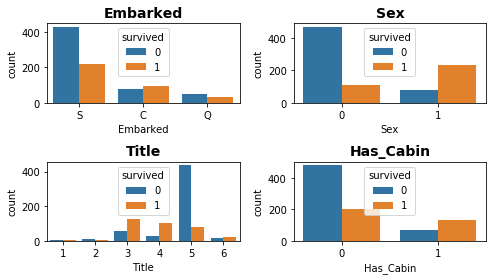

In [25]:
cols =['Embarked','Sex','Title','Has_Cabin']
nr_rows = 2
nr_cols = 2

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*2))

for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        
        i = r*nr_cols+c       
        ax = axs[r][c]
        sns.countplot(train[cols[i]], hue=train["Survived"], ax=ax)
        ax.set_title(cols[i], fontsize=14, fontweight='bold')
        ax.legend(title="survived", loc='upper center') 
        
plt.tight_layout()

In [45]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# for df_train_ml
scaler.fit(train.drop(['Survived'],axis=1))
scaled_features = scaler.transform(train.drop(['Survived'],axis=1))
df_train_ml_sc = pd.DataFrame(scaled_features) # columns=df_train_ml.columns[1::])

# for df_test_ml
test.fillna(test.mean(), inplace=True)
#scaler.fit(df_test_ml)
scaled_features = scaler.transform(test)
df_test_ml_sc = pd.DataFrame(scaled_features) # , columns=df_test_ml.columns)

In [59]:
X = train.drop('Survived',axis = 1)
y = train['Survived']
X.fillna(test.mean(),inplace = True)
X_test = test.drop('Survived', axis = 1)
y = test['Survived']

KeyError: "['Survived'] not found in axis"

In [52]:
from sklearn import tree
from sklearn.linear_model import LogisticRegression

In [57]:
log_clf = LogisticRegression()
log_clf.fit(X,y)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)